# Process ContentWise Data

**Goal**: convert ContentWise dataset into pandas format that can be used to train simulator. Infrequent users and items are discarded, a column adding dynamic user state is added, and the dataset is split into train, validate, test users seen in training, and test for users unseen in training.
<br/>
<br/>

In [1]:
import paths
%cd {paths.base}
import os
from os.path import join

%load_ext autoreload
%autoreload 2
from simtrain import utils
from simtrain import SETTINGS_POLIMI as SETTINGS
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import scipy
from scipy import stats, sparse
import shutil
from datetime import datetime
from tqdm.notebook import tqdm, trange
import time    # to be used in loop iterations
import json

os.environ['NUMEXPR_MAX_THREADS'] = SETTINGS.NUMEXPR_MAX_THREADS

c:\Users\nicol\anaconda3\envs\WW\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


C:\Users\nicol\github\Warwick\accordion


In [ ]:
path_neg_imp = paths.cw_dat_paths['negative_impressions']
path_pos_imp = paths.cw_dat_paths['positive_impressions']
path_clicks = paths.cw_dat_paths['interactions']

In [ ]:
df_neg = pd.read_csv(path_neg_imp)
df_pos = pd.read_csv(path_pos_imp)
df_int = pd.read_csv(path_clicks)
len(df_neg), len(df_pos), len(df_int)

In [ ]:
len(df_neg), len(df_pos), len(df_int)

### Next step: process positive impressions, negative impressions, and interactions into a single dataframe
Warning: the next cell is memory intensive and will take a long time.

In [ ]:
def parse_items(s):
    # convert string representation of items to list of int
    return [int(s0) for s0 in s.split('[')[1].split(']')[0].split(' ') if len(s0)>0]

# populate positive impressions:
df_pos_merged = df_pos.merge(df_int, on='recommendation_id', how='inner')

def convert_ms_days(t0, baseline):
    return (t0 - baseline)/1000/3600/24

start_time_ms = df_pos_merged.utc_ts_milliseconds.min()

UID = []
REC = []
ITM = []
TS = []
RS = []

print('processing interactions:')
print("len(df_pos_merged): ", len(df_pos_merged))
for ind,row in tqdm(df_pos_merged.iterrows()):
    vs = parse_items(row.recommended_series_list)
    c = row.recommendation_list_length
    assert len(vs)==c
    v1 = row.series_id
    assert v1 in vs
    t = convert_ms_days(row.utc_ts_milliseconds, start_time_ms)
    # create set of new rows with same rec_id and user_id
    UID += c*[row.user_id]
    REC += c*[row.row_position]
    ITM += vs
    TS += c*[t]
    RS += [((v0==v1) & (row.interaction_type==0)) for v0 in vs]

    
df = pd.DataFrame({'user_id':np.array(UID,dtype='int32'), 
                   'rec_id':np.array(REC,dtype='int32'),
                   'item_id':np.array(ITM,dtype='int32'), 
                   't':np.array(TS,dtype='float32'),
                    'reward':np.array(RS,dtype='float32')})
    
# group all positive events by user:
user_sessions = df[df.reward].groupby('user_id')
# keep users who have more than one play: 
valid_users = user_sessions.filter(lambda x: len(x)>1).user_id.unique()

print('\n\nprocessing negative impressions:')
print("df_neg: ",len(df_neg))

# populate negative impressions:
for ind, row in tqdm(df_neg.iterrows()):
    uid = int(row.user_id)
    if uid in valid_users:
        vs = parse_items(row.recommended_series_list)
        c = row.recommendation_list_length
        # pick random true session for user and assign same timestamp:
        t = user_sessions.get_group(uid).t.sample(n=1)
        # create set of new rows with same rec_id and user_id
        UID += c*[uid]
        REC += c*[int(row.row_position)]
        ITM += vs
        TS += c*[t]
        RS += c*[0]

df_full = pd.DataFrame({'user_id':np.array(UID,dtype='int32'), 
                   'rec_id':np.array(REC,dtype='int32'),
                   'item_id':np.array(ITM,dtype='int32'), 
                   't':np.array(TS,dtype='float32'),
                    'reward':np.array(RS,dtype='float32')})
    
# init user state and cell id with dummary vars for now:
df_full['user_state'] = ''
df_full['cell_id'] = 1

df_full

In [ ]:
len(UID), len(REC), len(ITM), len(TS), len(RS)

In [ ]:
UID2 = np.array(UID, dtype='int32')
REC2 = np.array(REC, dtype='int32')
ITM2 = np.array(ITM, dtype='int32')
TS2 = np.array(TS, dtype='float32')
RS2 = np.array(RS, dtype='float32')

# Verify lengths
assert len(UID2) == len(REC2) == len(ITM2) == len(TS2) == len(RS2)

In [ ]:
df_full.reward

In [ ]:
df_full = pd.DataFrame({'user_id':UID, 
                   'rec_id':REC,
                   'item_id':ITM, 
                   't':TS,
                    'reward':RS,}
                    )

In [ ]:
df_full['user_state'] = ''
df_full['cell_id'] = 1

#df_full.to_csv(paths.cw_stages['intermediate_0'], compression='gzip')

In [ ]:
df_full = pd.read_csv(paths.cw_stages['intermediate_0'])

In [ ]:
len(df_full)

In [ ]:
found = 0
for index, row in df_full.iterrows():
    print(row)
    found +=1
    if found >20:
        break

In [ ]:
def clean_ts_value(value):
    if isinstance(value, str):
        value = value.split()[1]  # Extract the numeric part
    return float(value)

clean_ts_value("7278048    27.36632\nName: t, dtype: float32")

In [ ]:
def clean_reward(value):
    if isinstance(value, bool):
        return value
    elif isinstance(value, int):
        return bool(value)
    elif isinstance(value, str):
        return value.lower() in ['true', '1']
    else:
        return False  # Handle unexpected cases as False

# Apply the function to the 'reward' column
clean_reward("False")

In [ ]:
found = 0
for index, row in df_full.iterrows():
    try:
        # Try to convert the value to float
        float_value = float(row['reward'])
    except ValueError:
        # If conversion fails, print the row
        print("_____"*50)
        print("row index: ", index)
        print(row)
        found +=1
        if found >20:
            break

In [ ]:
df_full['reward'] = df_full['reward'].apply(clean_reward)

In [ ]:
def clean_t_column(value):
    # Extract the second number in the string
    if isinstance(value, str):
        parts = value.split()
        if len(parts) > 1:
            return float(parts[1])
    return float(value)

# Apply the function to the 't' column
df_full['t'] = df_full['t'].apply(clean_t_column)


In [ ]:
df_full.dtypes

In [ ]:
df_full['reward'] = df_full['reward'].astype("bool")
df_full['t'] = df_full['t'].astype("float32")
df_full['item_id'] = df_full['item_id'].astype("int32")
df_full['rec_id'] = df_full['rec_id'].astype("int32")
df_full['user_id'] = df_full['user_id'].astype("int32")


In [ ]:
df_full['user_state'] = ''
df_full['cell_id'] = 1

In [ ]:
df_full.dtypes

In [ ]:
len(df_full)

In [ ]:
#filter bad 
#df_full['t'] = pd.to_numeric(df_full['t'], errors='coerce')

# Drop rows with NaN values in the column
#df_full = df_full.dropna(subset=['t'])

#df_full['reward'] = pd.to_numeric(df_full['reward'], errors='coerce')

# Drop rows with NaN values in the column
#df_full = df_full.dropna(subset=['reward'])
#len(df_full)

In [ ]:
'''
df_full = pd.DataFrame({'user_id':np.array(UID,dtype='int32'), 
                   'rec_id':np.array(REC,dtype='int32'),
                   'item_id':np.array(ITM,dtype='int32'), 
                   't':np.array(TS,dtype='float32'),
                    'reward':np.array(RS,dtype='float32')})
    
# init user state and cell id with dummary vars for now:
df_full['user_state'] = ''
df_full['cell_id'] = 1

df_full
'''

In [2]:
path_extra = r'C:\Users\nicol\github\Warwick\ContentWiseImpressions\data\ContentWiseImpressions\CW10M-CSV\processed-0.6.csv.gz'

In [ ]:
# save intermediary dataframe:
#path_extra = r'C:\Users\nicol\github\Warwick\ContentWiseImpressions\data\ContentWiseImpressions\CW10M-CSV\processed-0.5.csv.gz'
df_full.to_csv(path_extra, compression='gzip')

In [3]:
#df_full = pd.read_csv(paths.cw_stages['intermediate_0'])
df_full =pd.read_csv(path_extra)

In [4]:
df_full.rename(columns={'t':'time',
                  'item_id':'original_action',
                  'user_state':'original_state'}, inplace=True)

In [5]:
df_full.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'user_id', 'rec_id', 'original_action',
       'time', 'reward', 'original_state', 'cell_id'],
      dtype='object')

In [6]:
df_full.drop(['Unnamed: 0.1', "Unnamed: 0"], axis=1, inplace=True)
df_full.columns

Index(['user_id', 'rec_id', 'original_action', 'time', 'reward',
       'original_state', 'cell_id'],
      dtype='object')

In [7]:
df_full.dtypes

user_id              int64
rec_id               int64
original_action      int64
time               float64
reward                bool
original_state     float64
cell_id              int64
dtype: object

In [8]:
df_full['reward'] = df_full['reward'].astype("bool")
df_full['time'] = df_full['time'].astype("float32")
df_full['original_action'] = df_full['original_action'].astype("int32")
df_full['rec_id'] = df_full['rec_id'].astype("int32")
df_full['user_id'] = df_full['user_id'].astype("int32")


In [9]:
len(df_full.user_id.unique())#only 30k users

30470

In [33]:
# sub-sample users to make everything downstream runnable with a smaller machine 
# (can change SETTINGS parameter if no limits on computation):
subsample_users = np.random.choice(df_full.user_id.unique(), 1000)
df = df_full[df_full.user_id.isin(subsample_users)]
df.shape

(5383162, 7)

In [34]:
# count actions and discard those with less than 100 impressions or less than 5 streams:
item_ic = df.groupby('original_action').original_action.count()
item_sc = df[df.reward].groupby('original_action').original_action.count()
keep_actions = item_ic[(item_ic >= 100) & (item_ic.index.isin(item_sc[item_sc>=5].index))].index

In [35]:
print('num. actions to keep', item_ic[item_ic>=10].index.shape)

num. actions to keep (4661,)


In [36]:
# map original action to sequential actions:

# step 1. build vocab and inverse vocab of action_id
vocab = np.sort(df[df.original_action.isin(keep_actions)].original_action.unique())
inv_vocab = -np.ones(vocab.max()+1, dtype='int64') # -1 means item id is out of set
for i,v in enumerate(vocab):
    inv_vocab[v] = i

print('num nonzero values:',len(np.where(inv_vocab>=0)[0]))
print('len vocab',len(vocab))
print('new vocab',vocab)

# now add a new column with the sequential action ids
action_map = pd.DataFrame({'original_action':vocab, 'action':np.arange(len(vocab),dtype='int64')})

X1 = pd.merge(df, action_map, how='inner', on='original_action')
X1

num nonzero values: 302
len vocab 302
new vocab [  181   397   434   470   817   901  1033  1163  1189  1272  1496  1631
  1686  1725  1771  2084  2110  2253  2269  2293  2454  2475  2497  2501
  2530  2565  2607  2920  2928  3053  3107  3134  3378  3477  3502  3505
  3660  3689  3702  3738  3740  3747  3826  3974  4157  4164  4260  4272
  4338  4498  4625  4636  4773  4862  4902  5101  5227  5303  5544  5631
  5751  5827  5914  6186  6192  6205  6674  6872  7157  7409  7411  7432
  7494  7499  7569  7588  7618  7677  7755  7805  8181  8246  8268  8277
  8369  8425  8598  8619  8777  8924  9056  9077  9239  9245  9327  9396
  9453  9473  9522  9570  9584  9642  9701  9715  9834  9909 10244 10413
 10432 10458 10515 10685 11027 11134 11238 11260 11292 11339 11441 11565
 11856 11964 11968 11995 12099 12158 12185 12252 12309 12326 12349 12421
 12436 12490 12738 12950 12982 13099 13112 13116 13117 13152 13273 13349
 13673 14006 14709 14716 14782 14903 15049 15069 15171 15256 15486 15524
 15

,user_id,rec_id,original_action,time,reward,original_state,cell_id,action
0,27603,0,13673,78.468414,False,NaN,1,144
1,27603,0,15810,78.468414,False,NaN,1,161
2,27603,0,16821,78.468414,False,NaN,1,165
3,27603,0,3826,78.468414,False,NaN,1,42
4,27603,0,26860,78.468414,False,NaN,1,279
...,...,...,...,...,...,...,...,...
3156985,42148,2,18326,51.548691,False,NaN,1,186
3156986,42148,2,15656,51.548691,False,NaN,1,158
3156987,42148,2,2920,51.548691,False,NaN,1,27
3156988,42148,2,21102,51.548691,False,NaN,1,218


In [37]:
# now add state representation column which is dynamic:

def create_dynamic_states(X):
    Xstream = X[X['reward']]
    print('num. positive actions',Xstream.shape)
    dynamic_states = [] # tracks user state changes, list of tuples [(user_id, time, state)]
    format_state = lambda xs: ':'.join(map(str,xs))
    for user_id,user_imp in X.groupby('user_id'):
        current_state = []
        ds = []
        # iterate over streams that exist in impression data (if any) and update:
        for name,imp in user_imp.sort_values('time')[['action','time','reward','rec_id']].iterrows():
            title = int(imp[0])
            time = imp[1]
            reward = imp[2]
            rec_id = int(imp[3])
            ds.append((user_id, time, title, format_state(current_state), rec_id, reward))
            current_state = current_state.copy()
            if reward: current_state.append(title)
        # only append dynamic states if there is a single stream for this user in the impressions
        if len(current_state)>0:
            dynamic_states += ds

    users,times,titles,states,recids,rewards = zip(*dynamic_states)
    return pd.DataFrame({'user_id':users, 'time':times, 'action':titles, 'state':states, 'rec_id':recids, 'reward':rewards})

In [38]:
 Xdyn_ = create_dynamic_states(X1)

num. positive actions (7337, 8)


C:\Users\nicol\AppData\Local\Temp\ipykernel_22608\1716257012.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  title = int(imp[0])
C:\Users\nicol\AppData\Local\Temp\ipykernel_22608\1716257012.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  time = imp[1]
C:\Users\nicol\AppData\Local\Temp\ipykernel_22608\1716257012.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  reward = imp[2]
C:\Users\nicol\AppData\Local\Temp\ipykernel_

In [16]:
# might be bugged

# parallelize across half as many cores because memory intensive:
cores = max(1, int(int(os.environ['NUMEXPR_MAX_THREADS'])/2))
#cores = int(os.environ['NUMEXPR_MAX_THREADS'])
# need to process each user state at the time of every impression, use parallelism to solve faster:
#Xdyn_ = utils.parallelize_fnc_groups(create_dynamic_states, X1, None, 'user_id', cores)

parallelizing across num. partitions 16


In [39]:
Xdyn_.to_csv(paths.cw_stages['intermediate_1'], compression='gzip')

In [40]:
Xdyn_ = pd.read_csv(paths.cw_stages['intermediate_1'])

In [41]:
# annotate original dataset with Xdyn:
X2 = pd.merge(X1, Xdyn_, on=['user_id','time','action'], how='left')

n sesions per user over 1 hour apart 10.92


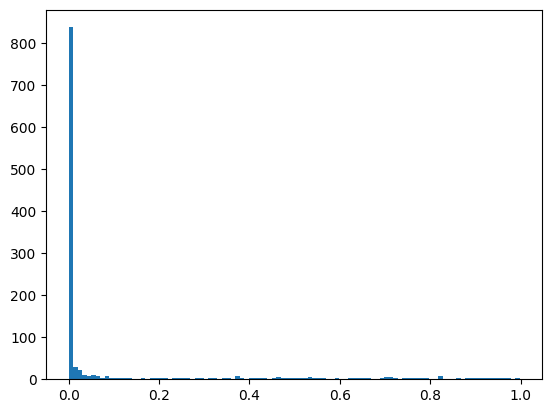

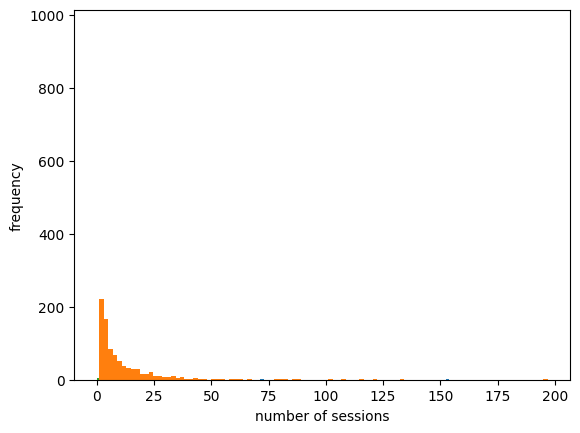

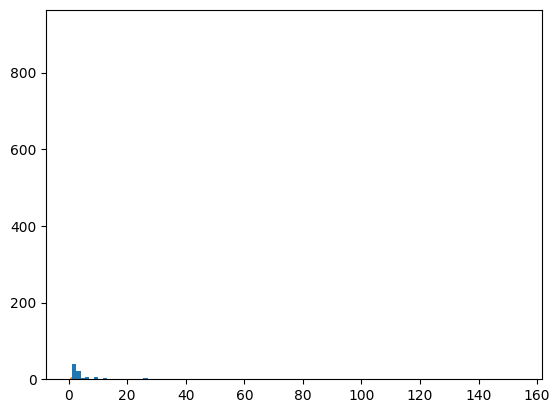

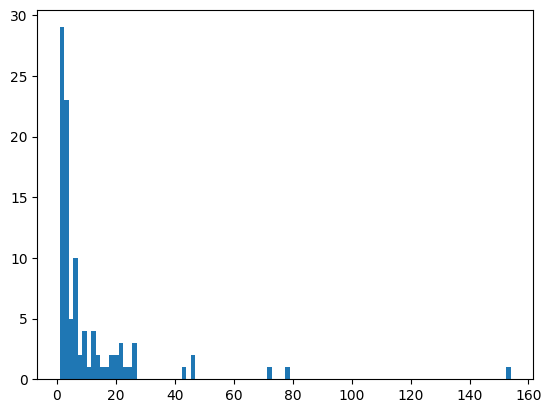

In [67]:
# look histogram of delta t between visits to decide whether further sessionization is needed:
# take subset of 500 users, do on individual level:
dt = []
n_sessions = []
n_sample_users = 100
HOURS_IN_DAY = 24
sub_users = np.random.choice(X1.user_id.unique(), n_sample_users)
for u in sub_users:
    t0 = X1[X1.user_id == u].sort_values('time').time.values
    dt_ = HOURS_IN_DAY*(t0[1:] - t0[:-1])
    n = len(np.unique(dt_[dt_>1.0]))
    n_sessions.append(1+n)
    dt += list(dt_[(dt_ > 0) & (dt_ < 1)])
plt.hist(dt,bins=100)
print('n sesions per user over 1 hour apart', sum(n_sessions)/n_sample_users)
plt.figure()
plt.hist(n_sessions,bins=100)
plt.show()

In [43]:
X3 = Xdyn_

In [45]:
# bucketize time into 30 min time slots:
X3['round_time'] = np.round(X3.time*48)/48

In [46]:
Xus = X3.groupby('user_id')

In [47]:
session_count = Xus.apply(lambda g: g.groupby('round_time').ngroups)

C:\Users\nicol\AppData\Local\Temp\ipykernel_22608\3342069100.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  session_count = Xus.apply(lambda g: g.groupby('round_time').ngroups)


In [48]:
plt.hist(session_count, bins=100)
plt.xlabel('number of sessions')
plt.ylabel('frequency')
pass

In [49]:
print('proportion of users with less than 5 sessions', 
      session_count[session_count < 5].shape[0] / session_count.shape[0])

proportion of users with less than 5 sessions 0.44521337946943484


In [50]:
# keep only those users with 5 or more sessions (discretized by 30 min slots)
keep_users = session_count[session_count >= 5].index
keep_users

Index([  188,   353,   371,   491,   547,   561,   637,   670,   707,   749,
       ...
       40946, 40989, 41151, 41346, 41751, 41862, 41911, 42048, 42063, 42148],
      dtype='int64', name='user_id', length=481)

In [51]:
X4 = X3[X3.user_id.isin(keep_users)]

In [63]:
# now split data into last 28 days test, train-validation-test 50-20-30, 
# remove users with no sessions in their respective quandrants

def split_dataset(X_, prop_train = 0.7, prop_test = 0.3, TEST_TIME_DAYS = 28, seed = 0):
    np.random.seed(seed)
    
    n_users = X_.user_id.nunique()
    user_set = X_.user_id.unique()
    
    train_user_ids = np.random.choice(np.arange(n_users,dtype='int64'), int(n_users*prop_train), replace=False)
    train_users = np.zeros(n_users, dtype='bool') #np.random.binomial(1, prop_train, size=n_users).astype('bool')
    train_users[train_user_ids] = True
    #val_users = (1-train_users)*np.random.binomial(1, prop_val/prop_train, size=n_users).astype('bool')
    test_users = (1 - train_users).astype('bool')
    
    print('stats: prop train users, test users', train_users.sum()/n_users, test_users.sum()/n_users)
    print('n_train_users',train_users.sum(), 'n_test_users',test_users.sum(), 'n_users', n_users)

    # now split by time and save to disk:
    max_time = X_.time.max()
    min_time = X_.time.min()
    print(min_time)
    #assert np.abs(min_time) < 1e-8# don't get why this is needed

    test_time = max_time - TEST_TIME_DAYS
    
    X_train = X_[(X_.time < test_time) & (X_.user_id.isin(user_set[train_users]))]
    X_val = X_[(X_.time < test_time) & (X_.user_id.isin(user_set[test_users]))]
    X_test_seen_users = X_[(X_.time >= test_time) & (X_.user_id.isin(user_set[train_users]))]
    X_test_unseen_users = X_[(X_.time >= test_time) & (X_.user_id.isin(user_set[test_users]))]
    
    N = X_.shape[0]
    print('data sizes as proportion of all data:', 'X_train', X_train.shape[0]/N, 'X_val', X_val.shape[0]/N, 
         'X_test_seen_users', X_test_seen_users.shape[0]/N, 'X_test_unseen_users', X_test_unseen_users.shape[0]/N)
    print('total imp check total', N, ': ', X_train.shape[0] + X_val.shape[0] + X_test_seen_users.shape[0] + X_test_unseen_users.shape[0])
    return [X_train, X_val, X_test_seen_users, X_test_unseen_users]

In [64]:
# save final outputs of processing to split files:

file_names = [paths.cw_stages['output']['train'],
             paths.cw_stages['output']['validate'],
             paths.cw_stages['output']['test-seen'],
             paths.cw_stages['output']['test-unseen']]

Xs = split_dataset(X4, seed=42)

for x,fn in zip(Xs, file_names):
    x.to_csv(fn, compression='gzip')
print('done.')

stats: prop train users, test users 0.6985446985446986 0.30145530145530147
n_train_users 336 n_test_users 145 n_users 481
0.0066435183398425
data sizes as proportion of all data: X_train 0.5463894384932335 X_val 0.23618843372660114 X_test_seen_users 0.14977738101306254 X_test_unseen_users 0.0676447467671028
total imp check total 2138407 :  2138407
done.


In [70]:
X4.user_id

1            188
2            188
3            188
4            188
5            188
           ...  
3112985    42148
3112986    42148
3112987    42148
3112988    42148
3112989    42148
Name: user_id, Length: 2138407, dtype: int64

In [71]:
# sanity check on state encoding: pick arbitrary users and see if their state matches their actions over time

def display_hist(uids):
    for uid in uids:
        print('uid',uid,'\n',X4[(X4.user_id == uid) & (X4.reward > 0)])
        print('\n\n')
    
display_hist([188, 42148])

uid 188 
       Unnamed: 0  user_id       time  action                          state  \
2              2      188   5.418762      74                            NaN   
959          959      188  12.258739     165                             74   
2554        2554      188  13.649942     195                         74:165   
3344        3344      188  13.705625     195                     74:165:195   
3897        3897      188  38.273819      74                 74:165:195:195   
5656        5656      188  83.310760     188              74:165:195:195:74   
6440        6440      188  83.342949     188          74:165:195:195:74:188   
6777        6777      188  84.676735     231      74:165:195:195:74:188:188   
7893        7893      188  84.710373     231  74:165:195:195:74:188:188:231   

      rec_id  reward  round_time  
2          0    True    5.416667  
959        0    True   12.250000  
2554       0    True   13.645833  
3344       0    True   13.708333  
3897       0    True   3